In [1]:
import os
import sys
import numpy as np
import multiprocessing as mp
from skimage.segmentation import find_boundaries

import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import shape, Polygon
from matplotlib.collections import PatchCollection

sys.path.append('../..')

In [2]:
from modis_utils.misc import cache_data, restore_data
from modis_utils.image_processing import mask_lake_img

In [3]:
n_cores = 24
patch_size = 32

In [4]:
water_threshold = (0.1 + 0.2001)/1.2001
percentile = restore_data('percentile/0.dat')
center_point_xs = np.arange(16, 513, 32)
center_point_xs

array([ 16,  48,  80, 112, 144, 176, 208, 240, 272, 304, 336, 368, 400,
       432, 464, 496])

In [5]:
permanent_water_area = np.where(percentile > 0.8, 1, 0)

# Utils functions

In [6]:
def find_boundaries_mask_lake(x, water_threshold):
    x1 = mask_lake_img(x, offset=water_threshold)
    return find_boundaries(x1)

In [7]:
def find_boundaries_mask_lake(x, water_threshold):
    x1 = mask_lake_img(x, offset=water_threshold)
    x1 = np.logical_or(x1, permanent_water_area)
    return find_boundaries(x1)

In [8]:
def get_pos(boundaries_img, center_point_xs):
    a = np.where(boundaries_img)
    res = []
    for x in center_point_xs:
        b = np.where(a[1] == x)[0]
        if len(b) > 1:
            choose_x1 = b[0]
            choose_x2 = b[-1]
            res.append((a[0][choose_x1], a[1][choose_x1]))
            res.append((a[0][choose_x2], a[1][choose_x2]))
    return res

In [9]:
def get_patch_coor(center_pos, sz):
    sz /= 2
    res = (center_pos[0] - sz, center_pos[0] + sz - 1, center_pos[1] - sz, center_pos[1] + sz - 1)
    return list(map(lambda x: int(x), res))

In [10]:
def get_polygon(c):
    y1, y2, x1, x2 = get_patch_coor(c, 32)
    return Polygon(((x1, y1), (x1, y2), (x2, y2), (x2, y1)))

In [11]:
def visualize_choose_patch(x, c):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(x)
    patches = []
    
    for x in c:
        p = get_polygon(x)
        patches.append(PolygonPatch(p, ec='red', fc='red', zorder=1))
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    ax.axis('off')
    plt.show()

In [12]:
def gen_data_1(sequence_data, water_threshold, patch_size):
    inputs, targets, inputs_pw, targets_pw = sequence_data
    last_inputs_pw = inputs[-1]
    a = find_boundaries_mask_lake(last_inputs_pw, water_threshold)
    list_center_pos = get_pos(a, center_point_xs)
    
    patches_inputs = []
    patches_targets = []
    patches_inputs_pw = []
    patches_targets_pw = []
    patch_size = 32
    
    outputs = [patches_inputs, patches_targets, patches_inputs_pw, patches_targets_pw]
    
    def padding(x, sz):
        res = np.zeros((x.shape[0], sz, sz))
        res[:, :x.shape[1], :x.shape[2]] = x
        return res
    
    for center_pos in list_center_pos:
        if len(center_pos) < 2:
            continue
        x1, x2, y1, y2 = get_patch_coor(center_pos, patch_size)
        for origin, patches in zip(sequence_data, outputs):
            patch = origin[:, x1 : x2+1, y1 : y2+1]
            if patch.shape[0] < patch_size - 1 or patch.shape[1] < patch_size - 1:
                patch = padding(patch, patch_size)
            patches.append(np.expand_dims(patch, axis=0))
    res = []
    for patches in outputs:
        res.append(np.vstack(patches))
    return res

In [13]:
def gen_data_2(data_dir, list_filenames, permanent_water_area, water_threshold, patch_size, output_dir):
    for filename in list_filenames:
        output_path = os.path.join(output_dir, filename)
        input_path = os.path.join(data_dir, filename)
        sequence_data = restore_data(input_path)
        res = gen_data_1(sequence_data, water_threshold, patch_size)
        cache_data(res, output_path)

In [14]:
def gen_data(data_dir, permanent_water_area, water_threshold, patch_size, output_dir):
    for data_type in ('train', 'val', 'test'):
        processes = []
        input_data_type_dir = os.path.join(data_dir, data_type)
        output_data_type_dir = os.path.join(output_dir, data_type)
        if not os.path.exists(output_data_type_dir):
            os.makedirs(output_data_type_dir)
        list_filenames = os.listdir(input_data_type_dir)
        n = len(list_filenames)
        print(n)

        m = n // n_cores
        r = n % n_cores
        start_pos = 0
        for i in range(n_cores):
            q = m + 1 if i < r else m
            p = mp.Process(target=gen_data_2, args=(input_data_type_dir, 
                                                    list_filenames[start_pos : start_pos + q],
                                                    permanent_water_area, water_threshold, patch_size,
                                                    output_data_type_dir))
            processes.append(p)
            start_pos += q

        for p in processes:
            p.start()
        for p in processes:
            p.join()

# Example

In [15]:
path = 'multiple_output/12/sequence_data/train/0.dat'
sequence_data = restore_data(path)
inputs, targets, inputs_pw, targets_pw = sequence_data
last_inputs_pw = inputs[-1]
a = find_boundaries_mask_lake(last_inputs_pw, water_threshold)
list_center_pos = get_pos(a, center_point_xs)

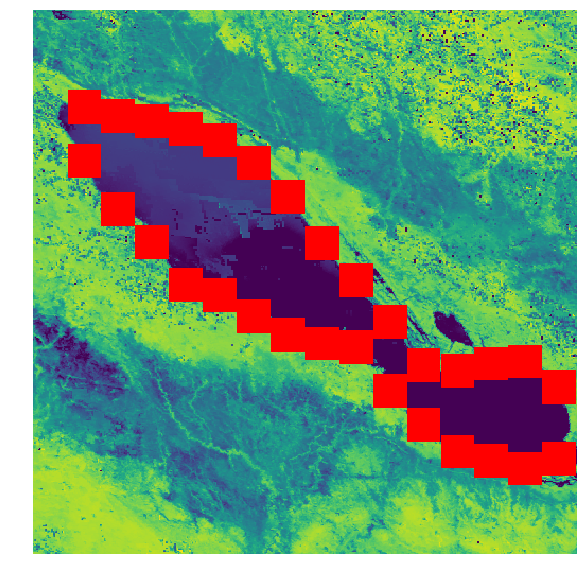

In [16]:
visualize_choose_patch(last_inputs_pw, list_center_pos)

# One output

In [17]:
data_dir = 'one_output/sequence_data'
output_dir = 'one_output/sequence_patch_data'

In [18]:
sample_shape = [x.shape for x in restore_data(os.path.join(data_dir, 'train', '0.dat'))]
sample_shape

[(14, 513, 513), (1, 513, 513), (14, 513, 513), (1, 513, 513)]

In [19]:
gen_data(data_dir, permanent_water_area, water_threshold, patch_size, output_dir)

529
46
92


In [20]:
path = os.path.join(output_dir, 'train', '0.dat')
a = restore_data(path)
for x in a:
    print(x.shape)

(30, 14, 32, 32)
(30, 1, 32, 32)
(30, 14, 32, 32)
(30, 1, 32, 32)


# Multiple output: 12

In [21]:
data_dir = 'multiple_output/12/sequence_data'
output_dir = 'multiple_output/12/sequence_patch_data'

In [22]:
sample_shape = [x.shape for x in restore_data(os.path.join(data_dir, 'train', '0.dat'))]
sample_shape

[(14, 513, 513), (12, 513, 513), (14, 513, 513), (12, 513, 513)]

In [23]:
gen_data(data_dir, permanent_water_area, water_threshold, patch_size, output_dir)

529
46
81


In [24]:
path = os.path.join(output_dir, 'train', '0.dat')
a = restore_data(path)
for x in a:
    print(x.shape)

(30, 14, 32, 32)
(30, 12, 32, 32)
(30, 14, 32, 32)
(30, 12, 32, 32)
